In [9]:
! pip install tensorflow

     |████████████████████████████████| 175.3 MB 80 kB/s  eta 0:00:01    |███▌                            | 18.9 MB 2.0 MB/s eta 0:01:18     |████▌                           | 24.6 MB 3.6 MB/s eta 0:00:43     |█████▏                          | 28.2 MB 2.4 MB/s eta 0:01:03     |██████                          | 32.9 MB 1.5 MB/s eta 0:01:38     |████████▉                       | 48.6 MB 3.6 MB/s eta 0:00:35     |█████████▉                      | 54.0 MB 169 kB/s eta 0:11:58     |██████████████████▍             | 100.7 MB 4.4 MB/s eta 0:00:17     |██████████████████▊             | 102.5 MB 1.8 MB/s eta 0:00:42     |███████████████████▎            | 105.5 MB 4.5 MB/s eta 0:00:16     |████████████████████████▋       | 134.7 MB 5.9 MB/s eta 0:00:07
     |████████████████████████████████| 42 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 454 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 2.0 MB/s eta 0:00:01
  Using cached termcolor-1.1.0.tar.gz (3.9 k

In [18]:
! pip install tensorflow_hub

     |████████████████████████████████| 101 kB 2.2 MB/s ta 0:00:01


In [ ]:
%cd '/Users/Simona/'

In [79]:
import Classifier
from Classifier import RF
from Classifier import LR
from Classifier import MLP

In [19]:
from torchvision import datasets, transforms
import torch
import tensorflow as tf
import tensorflow_hub as hub

In [20]:
import numpy as np

In [155]:
# Set the image transforms
train_transform = transforms.Compose([transforms.Resize(50)])
                                  
val_transform = transforms.Compose([transforms.Resize(50)])

In [156]:
train_dataset =  datasets.ImageFolder('/Users/Simona/Fresno_Area/train', transform=train_transform)
val_dataset =  datasets.ImageFolder('/Users/Simona/Fresno_Area/val', transform=val_transform)
test_dataset =  datasets.ImageFolder('/Users/Simona/Fresno_Area/test', transform=val_transform)

# Resnet50 pretrained on Resisc45

In [54]:
classifier_url = "https://tfhub.dev/google/remote_sensing/resisc45-resnet50/1"

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [73]:
# Embed tiles
n_tiles = len(train_dataset)
z_dim = 2048 #Model output embeddings size
X_train = np.zeros((n_tiles, z_dim))
for idx in range(0,n_tiles):
    tile = train_dataset[idx][0]
    tile = np.asarray(tile)
    tile = tile/255.0
    tile = classifier.predict(tile[np.newaxis, ...])
    X_train[idx,:] = tile

In [74]:
# Embed tiles
n_tiles = len(test_dataset)
z_dim = 2048  #Model output embeddings size
X_test = np.zeros((n_tiles, z_dim))
for idx in range(n_tiles):
    tile = test_dataset[idx][0]
    tile = np.asarray(tile)
    tile = tile/255.0
    tile = classifier.predict(tile[np.newaxis, ...])
    X_test[idx,:] = tile

In [76]:
np.savetxt('/Users/Simona/Fresno_Area/X_train_resnet50resisc45',X_train)
np.savetxt('/Users/Simona/Fresno_Area/X_test_resnet50resisc45',X_test)

In [80]:
RF(X_train,X_test)
LR(X_train,X_test)
MLP(X_train,X_test)

Mean accuracy: 0.8601
Standard deviation: 0.0218
Mean accuracy: 0.6643
Standard deviation: 0.0135
Mean accuracy: 0.9007
Standard deviation: 0.0217


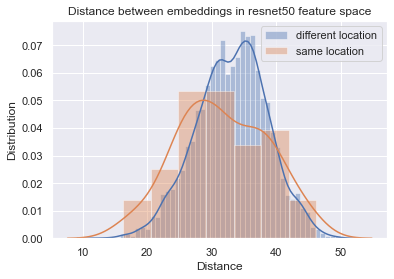

In [75]:
from numpy.linalg import norm
distance_to_ = []
for i in range(0,X_test.shape[0]):
  sublist = []
  for j in range(0,X_test.shape[0]):
    labels = tuple([test_dataset[i][1],test_dataset[j][1]])
    sublist.append(tuple([norm(X_test[i]-X_test[j]),labels]))
  distance_to_.append(sublist)

x_neg = []
x_pos = []
x_arr_neg = np.asarray([0]*len(test_dataset))
x_arr_pos = np.asarray([0]*len(test_dataset))
x_arr_neg_list = []
x_arr_pos_list = []
x_arr_labels_list = []
x_arr_labels_list_n = []

for i in range(0,int(len(distance_to_)/2)):
  x_n_ = []
  x_p_ = []
  x_p_labels = []
  x_n_labels = []
  x_n_labels_raw = []
  for j in range(0,int(len(distance_to_)/2)):
    if distance_to_[i*2+1][j*2][1][1] == i:
      x_p_.append(distance_to_[i*2+1][j*2][0]) 
      x_p_labels.append(i)
    else:
      x_n_.append(distance_to_[i*2+1][j*2][0])
      x_n_labels.append((i*2+1,j*2))
      x_n_labels_raw.append((i,j))
  x_arr_neg_ = np.asarray(x_n_)
  x_arr_pos_ = np.asarray(x_p_)
  x_arr_neg_list.append(x_arr_neg_)
  #x_arr_pos = x_arr_pos + x_arr_pos_
  x_arr_pos_list.append(x_arr_pos_)
  x_arr_labels_list.append(x_p_labels)
  x_arr_labels_list_n.append(x_n_labels_raw)
  x_mean_neg = np.mean(x_arr_neg, axis=0)
  x_mean_pos = np.mean(x_arr_pos, axis=0)
  x_std_neg = np.std(x_arr_neg, axis=0)
  x_std_pos = np.std(x_arr_pos, axis=0)

import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set()
x = x_arr_neg_list
x_2 =  x_arr_pos_list
ax = sns.distplot(x,label="different location")
ax = sns.distplot(x_2,label="same location")
ax.set(xlabel='Distance', ylabel='Distribution')
plt.title("Distance between embeddings in resnet50 feature space") 
plt.legend()
plt.show()

# PCA

In [101]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.9)

In [113]:
# Embed tiles
n_tiles = len(train_dataset)
z_dim = 3*50*50
X_train = np.zeros((n_tiles, z_dim))

for idx in range(n_tiles):
    tile = train_dataset[idx][0]
    tile = np.asarray(tile)
    tile = tile/255.0
    tile_2d = tile.reshape(z_dim)
    tile = tile_2d.reshape(-1, 1)
    tile = pca.fit_transform(tile)
    tile = np.moveaxis(tile, -1, 0)
    X_train[idx,:] = tile

In [117]:
X_train

array([[-0.14055477,  0.02415111,  0.02415111, ..., -0.1248685 ,
         0.00454327,  0.00454327],
       [-0.05928366, -0.02398954,  0.07404967, ..., -0.07104837,
        -0.01614641,  0.07404967],
       [-0.14440837, -0.00715346, -0.00715346, ..., -0.12087895,
         0.00853281,  0.00853281],
       ...,
       [ 0.02009516,  0.01617359,  0.06323242, ..., -0.05049307,
        -0.01912052,  0.03970301],
       [ 0.06152105, -0.00906719, -0.00906719, ...,  0.00269752,
        -0.05612601, -0.05612601],
       [ 0.05170458, -0.0384915 , -0.05025621, ...,  0.07523399,
        -0.02280523, -0.04241307]])

In [114]:
# Embed tiles
n_tiles = len(test_dataset)
z_dim = 3*50*50
X_test = np.zeros((n_tiles, z_dim))

for idx in range(n_tiles):
    tile = test_dataset[idx][0]
    tile = np.asarray(tile)
    tile = tile/255.0
    tile_2d = tile.reshape(z_dim)
    tile = tile_2d.reshape(-1, 1)
    tile = pca.fit_transform(tile)
    tile = np.moveaxis(tile, -1, 0)
    X_test[idx,:] = tile

In [118]:
np.savetxt('/Users/Simona/Fresno_Area/X_train_PCA',X_train)
np.savetxt('/Users/Simona/Fresno_Area/X_test_PCA',X_test)

In [124]:
RF(X_train,X_test)
LR(X_train,X_test)
MLP(X_train,X_test)

Mean accuracy: 0.7086
Standard deviation: 0.0305
Mean accuracy: 0.5431
Standard deviation: 0.0168
Mean accuracy: 0.7267
Standard deviation: 0.0280


In [119]:
from numpy.linalg import norm
distance_to_ = []
for i in range(0,X_test.shape[0]):
  sublist = []
  for j in range(0,X_test.shape[0]):
    labels = tuple([test_dataset[i][1],test_dataset[j][1]])
    sublist.append(tuple([norm(X_test[i]-X_test[j]),labels]))
  distance_to_.append(sublist)

In [120]:
x_neg = []
x_pos = []
x_arr_neg = np.asarray([0]*len(test_dataset))
x_arr_pos = np.asarray([0]*len(test_dataset))
x_arr_neg_list = []
x_arr_pos_list = []
x_arr_labels_list = []
x_arr_labels_list_n = []

for i in range(0,int(len(distance_to_)/2)):
  x_n_ = []
  x_p_ = []
  x_p_labels = []
  x_n_labels = []
  x_n_labels_raw = []
  for j in range(0,int(len(distance_to_)/2)):
    if distance_to_[i*2+1][j*2][1][1] == i:
      x_p_.append(distance_to_[i*2+1][j*2][0]) 
      x_p_labels.append(i)
    else:
      x_n_.append(distance_to_[i*2+1][j*2][0])
      x_n_labels.append((i*2+1,j*2))
      x_n_labels_raw.append((i,j))
  x_arr_neg_ = np.asarray(x_n_)
  x_arr_pos_ = np.asarray(x_p_)
  x_arr_neg_list.append(x_arr_neg_)
  #x_arr_pos = x_arr_pos + x_arr_pos_
  x_arr_pos_list.append(x_arr_pos_)
  x_arr_labels_list.append(x_p_labels)
  x_arr_labels_list_n.append(x_n_labels_raw)
  x_mean_neg = np.mean(x_arr_neg, axis=0)
  x_mean_pos = np.mean(x_arr_pos, axis=0)
  x_std_neg = np.std(x_arr_neg, axis=0)
  x_std_pos = np.std(x_arr_pos, axis=0)

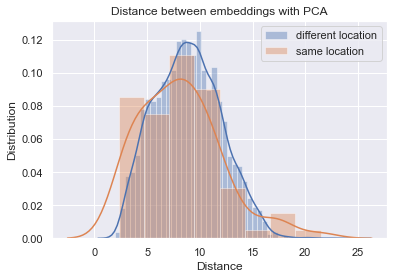

In [121]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set()
x = x_arr_neg_list
x_2 =  x_arr_pos_list
ax = sns.distplot(x,label="different location")
ax = sns.distplot(x_2,label="same location")
ax.set(xlabel='Distance', ylabel='Distribution')
plt.title("Distance between embeddings with PCA") 
plt.legend()
plt.show()

# K-means

In [122]:
! pip install kmeans_pytorch

In [123]:
import random
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from numpy.linalg import norm
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

K-means: Tiles are clustered in pixel space using k-means with k = 10, and each tile is represented
as 10-dimensional vectors of distances to each cluster centroid.

In [ ]:
# data
data_size, num_clusters = len(train_dataset),int(len(train_dataset)/2)

# Embed tiles
n_tiles = len(train_dataset)
z_dim = 100
X_train = np.zeros((n_tiles,z_dim*z_dim*3))

for idx in range(n_tiles):
    tile = train_dataset[idx][0]
    tile = np.asarray(tile)
    tile = tile / 255.0
    tile = tile.reshape(z_dim*z_dim*3)
    tile = torch.from_numpy(tile)
    X_train[idx,:] = tile

In [ ]:
# data
data_size, num_clusters = len(test_dataset),int(len(test_dataset)/2)

# Embed tiles
n_tiles = len(test_dataset)
z_dim = 100
X_test = np.zeros((n_tiles,z_dim*z_dim*3))
#print(X_train.shape)

for idx in range(n_tiles):
    tile = test_dataset[idx][0]
    tile = np.asarray(tile)
    tile = tile / 255.0
    #print(tile.shape)
    tile = tile.reshape(z_dim*z_dim*3)
    tile = torch.from_numpy(tile)
    X_test[idx,:] = tile

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=int(len(train_dataset)/2))
X_train_kmeans = kmeans.fit_transform(X_train)
np.savetxt('/content/drive/My Drive/X_train_kmeans',X_train_kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1162, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=int(len(test_dataset)/2))
X_test_kmeans = kmeans.fit_transform(X_test)
np.savetxt('/content/drive/My Drive/X_test_kmeans',X_test_kmeans)

In [ ]:
RF(X_train_kmeans,,X_test_kmeans)
LR(X_train_kmeans,,X_test_kmeans)
MLP(X_train_kmeans,,X_test_kmeans)

# Raw features

In [137]:
# Embed tiles
n_tiles = len(train_dataset)
z_dim = 3*50*50
X_train = np.zeros((n_tiles, z_dim))

for idx in range(n_tiles):
    tile = train_dataset[idx][0]
    tile = np.asarray(tile)
    tile_2d = tile.reshape(z_dim)
    tile = tile_2d.reshape(-1, 1)
    #print(tile)
    tile = np.moveaxis(tile, -1, 0)
    #print(tile.shape)
    X_train[idx,:] = tile

In [138]:
X_train.shape

(2324, 7500)

In [150]:
test = np.zeros((0, 2))
test

array([], shape=(0, 2), dtype=float64)

In [151]:
test.reshape(-1, 1)
test

array([], shape=(0, 2), dtype=float64)

In [157]:
# Embed tiles
n_tiles = len(test_dataset)
z_dim = 3*50*50
X_test = np.zeros((n_tiles, z_dim))

for idx in range(n_tiles):
    tile = test_dataset[idx][0]
    tile = np.asarray(tile)
    print("1",tile.shape)
    tile_2d = tile.reshape(z_dim)
    print("2",tile_2d.shape)
    tile = tile_2d.reshape(-1, 1) #first dim stays the same, one dim added to second dim 
    print("3",tile.shape)
    tile = np.moveaxis(tile, -1, 0)
    print("4",tile.shape)
    X_test[idx,:] = tile

1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1, 7500)
1 (50, 50, 3)
2 (7500,)
3 (7500, 1)
4 (1

In [158]:
X_test.shape

(166, 7500)

In [159]:
np.savetxt('/Users/Simona/Fresno_Area/X_train_raw',X_train)
np.savetxt('/Users/Simona/Fresno_Area/X_test_raw',X_test)

In [ ]:
RF(X_train,X_test)
LR(X_train,X_test)
MLP(X_train,X_test)

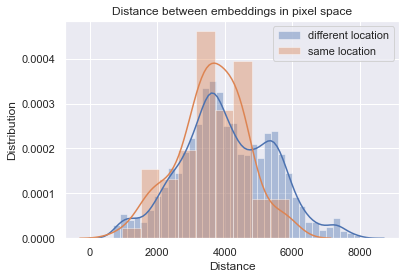

In [142]:
from numpy.linalg import norm
distance_to_ = []
for i in range(0,X_test.shape[0]):
  sublist = []
  for j in range(0,X_test.shape[0]):
    labels = tuple([test_dataset[i][1],test_dataset[j][1]])
    sublist.append(tuple([norm(X_test[i]-X_test[j]),labels]))
  distance_to_.append(sublist)

x_neg = []
x_pos = []
x_arr_neg = np.asarray([0]*len(test_dataset))
x_arr_pos = np.asarray([0]*len(test_dataset))
x_arr_neg_list = []
x_arr_pos_list = []
x_arr_labels_list = []
x_arr_labels_list_n = []

for i in range(0,int(len(distance_to_)/2)):
  x_n_ = []
  x_p_ = []
  x_p_labels = []
  x_n_labels = []
  x_n_labels_raw = []
  for j in range(0,int(len(distance_to_)/2)):
    if distance_to_[i*2+1][j*2][1][1] == i:
      x_p_.append(distance_to_[i*2+1][j*2][0]) 
      x_p_labels.append(i)
    else:
      x_n_.append(distance_to_[i*2+1][j*2][0])
      x_n_labels.append((i*2+1,j*2))
      x_n_labels_raw.append((i,j))
  x_arr_neg_ = np.asarray(x_n_)
  x_arr_pos_ = np.asarray(x_p_)
  x_arr_neg_list.append(x_arr_neg_)
  #x_arr_pos = x_arr_pos + x_arr_pos_
  x_arr_pos_list.append(x_arr_pos_)
  x_arr_labels_list.append(x_p_labels)
  x_arr_labels_list_n.append(x_n_labels_raw)
  x_mean_neg = np.mean(x_arr_neg, axis=0)
  x_mean_pos = np.mean(x_arr_pos, axis=0)
  x_std_neg = np.std(x_arr_neg, axis=0)
  x_std_pos = np.std(x_arr_pos, axis=0)

import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set()
x = x_arr_neg_list
x_2 =  x_arr_pos_list
ax = sns.distplot(x,label="different location")
ax = sns.distplot(x_2,label="same location")
ax.set(xlabel='Distance', ylabel='Distribution')
plt.title("Distance between embeddings in pixel space") 
plt.legend()
plt.show()

In [ ]:
!python3 -m pip install SSIM-PIL

## How to do Seaborn Noise Plots

## Similarity of Feature Vectors

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import torch
import torchvision.transforms as transforms
import scipy

In [ ]:
classifier_url = "https://tfhub.dev/google/remote_sensing/resisc45-resnet50/1"
#classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
#classifier_url = "https://tfhub.dev/google/tf2-preview/inception_v3/classification/4"

In [ ]:
classifier_url = "https://tfhub.dev/google/remote_sensing/resisc45-resnet50/1"
#classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
#classifier_url = "https://tfhub.dev/google/tf2-preview/inception_v3/classification/4"

IMAGE_SHAPE = (224, 224)
#IMAGE_SHAPE = (299, 299)


classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

Feature_vec_drone_image = classifier.predict(np_drone[np.newaxis, ...])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
for i in range(18,19):
  #print(i)
  drone_url = images_sentinel[i]
  planet_url = images_naip[i]
  #response = requests.get(drone_url)
  drone_img = Image.open(drone_url)
  planet_img = Image.open(planet_url)
  #planet_img = planet_img.convert('RGB')
  print(drone_img.size)
  drone_img_rs = drone_img.resize((224, 224))
  print(drone_img_rs.size)
  planet_img_rs = planet_img.resize((224, 224))

(200, 200)
(224, 224)


In [ ]:
x_3 = []
for i in range(1,19):
  num = 12*i
  if (num % 2) != 0:
    num = num+1
  x_3.append(num)
  if i == 18:
    x_3.append(224)
  #print(x_3)
x_3

[12,
 24,
 36,
 48,
 60,
 72,
 84,
 96,
 108,
 120,
 132,
 144,
 156,
 168,
 180,
 192,
 204,
 216,
 224]

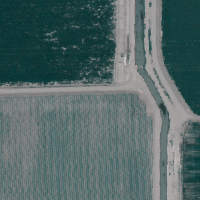

In [ ]:
planet_img

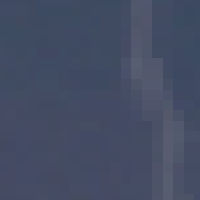

In [ ]:
import cv2
drone_img

In [ ]:
#right time, right location experiment with feature vectors

MSE_global_fv_r = []
COS_global_fv_r = []
images = [] 

for i in range(0,20):
  drone_url = images_sentinel[i]
  planet_url = images_naip[i]
  time = "TRUE"
  drone_img = Image.open(drone_url)
  planet_img = Image.open(planet_url)
  drone_img_rs = drone_img.resize((224, 224))
  planet_img_rs = planet_img.resize((224, 224))
  images.append(drone_img_rs)
  images.append(planet_img_rs)
  
  x_3 = []
  for i in range(1,19):
    num = 12*i
    if (num % 2) != 0:
      num = num+1
    x_3.append(num)
    if i == 18:
      x_3.append(224)
    #print(x_3)

  MSE_tt = []
  COS_tt = []
  if time == "TRUE":
    for i in range(0,19):
      if i in range(0,18):
        #print(i)
        width = x_3[i]/2
        #print((112 - width, 112 - width,112 + width, 112 + width))
        cropped_drone_img_fv = drone_img_rs.crop((112 - width, 112 - width,112 + width, 112 + width)).resize((224, 224))
        cropped_planet_img_fv  =  planet_img_rs.crop((112 - width, 112  - width, 112  + width,112  + width)).resize((224, 224))
        np_drone = np.array(cropped_drone_img_fv)
        np_planet = np.array(cropped_planet_img_fv)
        Feature_vec_drone_image = classifier.predict(np_drone[np.newaxis, ...])
        Feature_vec_planet_image = classifier.predict(np_planet[np.newaxis, ...])
        MSE_tt.append(metrics.mean_squared_error(Feature_vec_drone_image, Feature_vec_planet_image))
        CO = (1 - scipy.spatial.distance.cosine(Feature_vec_planet_image,Feature_vec_drone_image))
        MSE_global_fv_r_2 = np.square(np.subtract(Feature_vec_drone_image,Feature_vec_planet_image)).mean() 
        COS_tt.append(CO)
      else:
        cropped_drone_img_fv = drone_img_rs
        cropped_planet_img_fv  =  planet_img_rs
        np_drone = np.array(cropped_drone_img_fv)
        np_planet = np.array(cropped_planet_img_fv)
        Feature_vec_drone_image = classifier.predict(np_drone[np.newaxis, ...])
        Feature_vec_planet_image = classifier.predict(np_planet[np.newaxis, ...])
        MSE_tt.append(metrics.mean_squared_error(Feature_vec_drone_image, Feature_vec_planet_image))
        CO = (1 - scipy.spatial.distance.cosine(Feature_vec_planet_image,Feature_vec_drone_image))
        COS_tt.append(CO)
        MSE_global_fv_r_2 = np.square(np.subtract(Feature_vec_drone_image,Feature_vec_planet_image)).mean() 
    MSE_global_fv_r.append(MSE_tt)
    COS_global_fv_r.append(COS_tt)


In [ ]:
images[8]

In [ ]:
x_3 = []
for i in range(1,20):
  num = 12*i
  if (num % 2) != 0:
    num = num+1
  x_3.append(num)
  if i == 42:
    x_3.append(512)
  #print(x_3)
x_3

In [ ]:
#right time, wrong location experiment with feature vectors

MSE_global_fv_wl = []
COS_global_fv_wl = []

def rotate(l, n):
  return l[n:] + l[:n]

for i in range(0,20):
  drone_url = images_sentinel[i]
  images_naip_rot = rotate(images_naip, 2)
  planet_url = images_naip_rot[i]
  #planet_url = images_naip[i]
  drone_img = Image.open(drone_url)
  planet_img = Image.open(planet_url)
  drone_img_rs = drone_img.resize((224, 224))
  planet_img_rs = planet_img.resize((224, 224))

  x_3 = []
  for i in range(1,19):
    num = 12*i
    if (num % 2) != 0:
      num = num+1
    x_3.append(num)
    if i == 18:
      x_3.append(224)
    #print(x_3)

  MSE_tt = []
  COS_tt = []
  images_cropped = []
  images_labels = []

  if time == "TRUE":
    for i in range(0,19):
      if i in range(0,18):
        width = x_3[i]/2
        #print(i)
        #print((112 - width, 112 - width, 112 + width, 112+ width))
        a = 112 - width
        b = 112 + width
        c = b - a
        cropped_drone_img_fv = drone_img_rs.crop((112 - width, 112 - width, 112 + width, 112+ width)).resize((224, 224))
        images_cropped.append(cropped_drone_img_fv ) 
        images_labels.append(c)
        cropped_planet_img_fv  =  planet_img_rs.crop((112 - width, 112 - width, 112 + width, 112+ width)).resize((224, 224))
        images_cropped.append(cropped_planet_img_fv) 
        images_labels.append(c)
        np_drone = np.array(cropped_drone_img_fv)
        np_planet = np.array(cropped_planet_img_fv)
        #print(np_drone.shape)
        Feature_vec_drone_image = classifier.predict(np_drone[np.newaxis, ...])
        Feature_vec_planet_image = classifier.predict(np_planet[np.newaxis, ...])
        #print(Feature_vec_drone_image )
        #print(Feature_vec_drone_image)
        #print(metrics.mean_squared_error(Feature_vec_drone_image.flatten(), Feature_vec_planet_image.flatten()))
        MSE_tt.append(metrics.mean_squared_error(Feature_vec_drone_image.flatten(), Feature_vec_planet_image.flatten()))
        CO = (1 - scipy.spatial.distance.cosine(Feature_vec_planet_image,Feature_vec_drone_image))
        COS_tt.append(CO)
      else:
        cropped_drone_img_fv = drone_img_rs
        images_cropped.append(cropped_drone_img_fv ) 
        c = 224
        images_labels.append(c)
        cropped_planet_img_fv  =  planet_img_rs
        images_cropped.append(cropped_planet_img_fv) 
        images_labels.append(c)
        np_drone = np.array(cropped_drone_img_fv)
        np_planet = np.array(cropped_planet_img_fv)
        #print(np_drone.shape)
        Feature_vec_drone_image = classifier.predict(np_drone[np.newaxis, ...])
        Feature_vec_planet_image = classifier.predict(np_planet[np.newaxis, ...])
        MSE_tt.append(metrics.mean_squared_error(Feature_vec_drone_image.flatten(), Feature_vec_planet_image.flatten()))
        CO = (1 - scipy.spatial.distance.cosine(Feature_vec_planet_image,Feature_vec_drone_image))
        COS_tt.append(CO)
    MSE_global_fv_wl.append(MSE_tt)
    COS_global_fv_wl.append(COS_tt)
    #print(MSE_tt)
    #print(COS_tt)

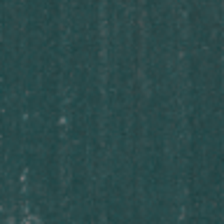

In [ ]:
images_cropped[15]

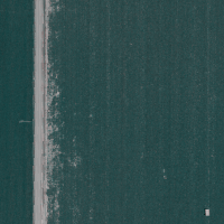

In [ ]:
images_cropped[37]

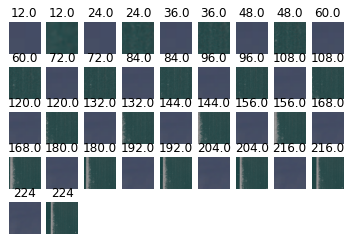

In [ ]:
import matplotlib.pyplot as plt
for i in range(0,len(images_cropped)):
    plt.subplot(5,9,i+1)
    plt.title(images_labels[i])
    plt.axis('off')
    plt.imshow(images_cropped[i])

In [ ]:
x_4 = [i*i for i in x_3]

In [ ]:
import pandas as pd 
df_fv_r = pd.DataFrame( MSE_global_fv_r, index =["image 1", "image 2", "image 3", "image 4", "image 5", "image 6","image 7", "image 8", "image 9","image 10","image 11", "image 12", "image 13", "image 14", "image 15", "image 16","image 17", "image 18", "image 19","image 20"], columns =x_4) 
#df_fv_wt = pd.DataFrame( MSE_global_fv_wt, index =["image 1", "image 2", "image 3", "image 4", "image 5", "image 6","image 7", "image 8", "image 9","image 10"], columns =x_4) 
df_fv_wl = pd.DataFrame( MSE_global_fv_wl, index =["image 1", "image 2", "image 3", "image 4", "image 5", "image 6","image 7", "image 8", "image 9","image 10","image 11", "image 12", "image 13", "image 14", "image 15", "image 16","image 17", "image 18", "image 19","image 20"], columns =x_4) 

tmp_df_fv_r = df_fv_r
#tmp_df_fv_wt = df_fv_wt
tmp_df_fv_wl = df_fv_wl

In [ ]:
import pandas as pd 
df_fv_r_C = pd.DataFrame( COS_global_fv_r, index =["image 1", "image 2", "image 3", "image 4", "image 5", "image 6","image 7", "image 8", "image 9","image 10","image 11", "image 12", "image 13", "image 14", "image 15", "image 16","image 17", "image 18", "image 19","image 20"], columns =x_4) 
#df_fv_wt_C = pd.DataFrame( COS_global_fv_wt, index =["image 1", "image 2", "image 3", "image 4", "image 5", "image 6","image 7", "image 8", "image 9","image 10"], columns =x_4) 
df_fv_wl_C = pd.DataFrame( COS_global_fv_wl, index =["image 1", "image 2", "image 3", "image 4", "image 5", "image 6","image 7", "image 8", "image 9","image 10","image 11", "image 12", "image 13", "image 14", "image 15", "image 16","image 17", "image 18", "image 19","image 20"], columns =x_4) 

tmp_df_fv_r_C = df_fv_r_C
#tmp_df_fv_wt_C = df_fv_wt_C
tmp_df_fv_wl_C = df_fv_wl_C

In [ ]:
A_fv_r = []

for j in tmp_df_fv_r.keys():
  row_df_fv_r = tmp_df_fv_r[j]
  #row_df_fv_wt = tmp_df_fv_wt[j]
  row_df_fv_wl = tmp_df_fv_wl[j]
  for row in row_df_fv_r.index: 
    a = [row, float(row_df_fv_r[row]), float(j), "rl"]
    #b = [row, float(row_df_fv_wt[row]), float(j), "wt-rl"]
    c = [row, float(row_df_fv_wl[row]), float(j), "wl"]
    A_fv_r += [a]
    #A_fv_r += [b]
    A_fv_r += [c]

new_pd_fv_r = pd.DataFrame(A_fv_r, columns=["Image", "MSE", "Meters", "Experiment"])
print(new_pd_fv_r)

        Image       MSE   Meters Experiment
0     image 1  0.700025    144.0         rl
1     image 1  0.726867    144.0         wl
2     image 2  0.533075    144.0         rl
3     image 2  1.703784    144.0         wl
4     image 3  0.755425    144.0         rl
..        ...       ...      ...        ...
755  image 18  1.521864  50176.0         wl
756  image 19  1.587377  50176.0         rl
757  image 19  1.680859  50176.0         wl
758  image 20  1.492587  50176.0         rl
759  image 20  1.471425  50176.0         wl

[760 rows x 4 columns]


In [ ]:
A_fv_r = []

for j in tmp_df_fv_r.keys():
  row_df_fv_r = tmp_df_fv_r_C[j]
  #row_df_fv_wt = tmp_df_fv_wt_C[j]
  row_df_fv_wl = tmp_df_fv_wl_C[j]
  for row in row_df_fv_r.index: 
    a = [row, float(row_df_fv_r[row]), float(j), "rl"]
    #b = [row, float(row_df_fv_wt[row]), float(j), "wt-rl"]
    c = [row, float(row_df_fv_wl[row]), float(j), "wl"]
    A_fv_r += [a]
    #A_fv_r += [b]
    A_fv_r += [c]

new_pd_fv_r_C = pd.DataFrame(A_fv_r, columns=["Image", "MSE", "Meters", "Experiment"])
print(new_pd_fv_r_C)

        Image       MSE   Meters Experiment
0     image 1  0.779912    144.0         rl
1     image 1  0.784376    144.0         wl
2     image 2  0.839522    144.0         rl
3     image 2  0.603413    144.0         wl
4     image 3  0.777073    144.0         rl
..        ...       ...      ...        ...
755  image 18  0.628858  50176.0         wl
756  image 19  0.590570  50176.0         rl
757  image 19  0.553611  50176.0         wl
758  image 20  0.642926  50176.0         rl
759  image 20  0.610850  50176.0         wl

[760 rows x 4 columns]


[Text(0, 0.5, 'MSE'), Text(0.5, 0, 'Area in $m^2$')]

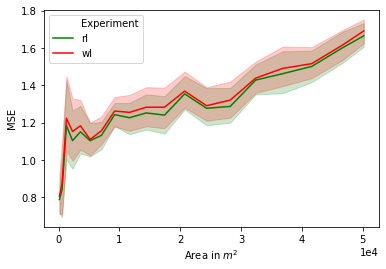

In [ ]:
import seaborn as sns
sns.set_palette("pastel")
plt = sns.lineplot(x="Meters", y="MSE",
             hue="Experiment",
             data=new_pd_fv_r, palette=["g","r"])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.set(xlabel="Area in $m^2$", ylabel='MSE')

[Text(0, 0.5, 'COS-Similarity'), Text(0.5, 0, 'Area in $m^2$')]

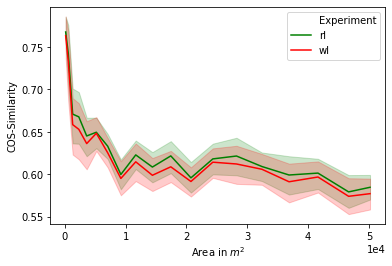

In [ ]:
import seaborn as sns
sns.set_palette("pastel")
plt = sns.lineplot(x="Meters", y="MSE",
             hue="Experiment",
             data=new_pd_fv_r_C, palette=["g","r"])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.set(xlabel="Area in $m^2$", ylabel='COS-Similarity')